# Environment

In [1]:
import torchaudio
import numpy as np
from torch import Tensor
import matplotlib.pyplot as plt
from IPython.display import Audio
from scipy.signal import find_peaks
from helpers.path_utils import get_base_dir
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks, decimate
from helpers.plot import plot_waveform_and_spectrograms, plot_audio_fft
from helpers.audio_utils import apply_bandpass_filter, min_max_scale

# Raw Heartbeat

In [12]:
AUDIO_NAME = "000-20240910-1753.wav"
audio_dir = get_base_dir().joinpath("data", "mobile", "last-trigger", AUDIO_NAME)

audio, sample_rate = torchaudio.load(str(audio_dir))
print("Sample rate: ", sample_rate)
audio.shape

Sample rate:  22050


torch.Size([1, 2723175])

# Keep just the first seconds to detect trigger

In [13]:
audio = audio[:, : 11 * sample_rate].clone()
audio.shape

torch.Size([1, 242550])

# Resample to match the digital stethoscope sample rate

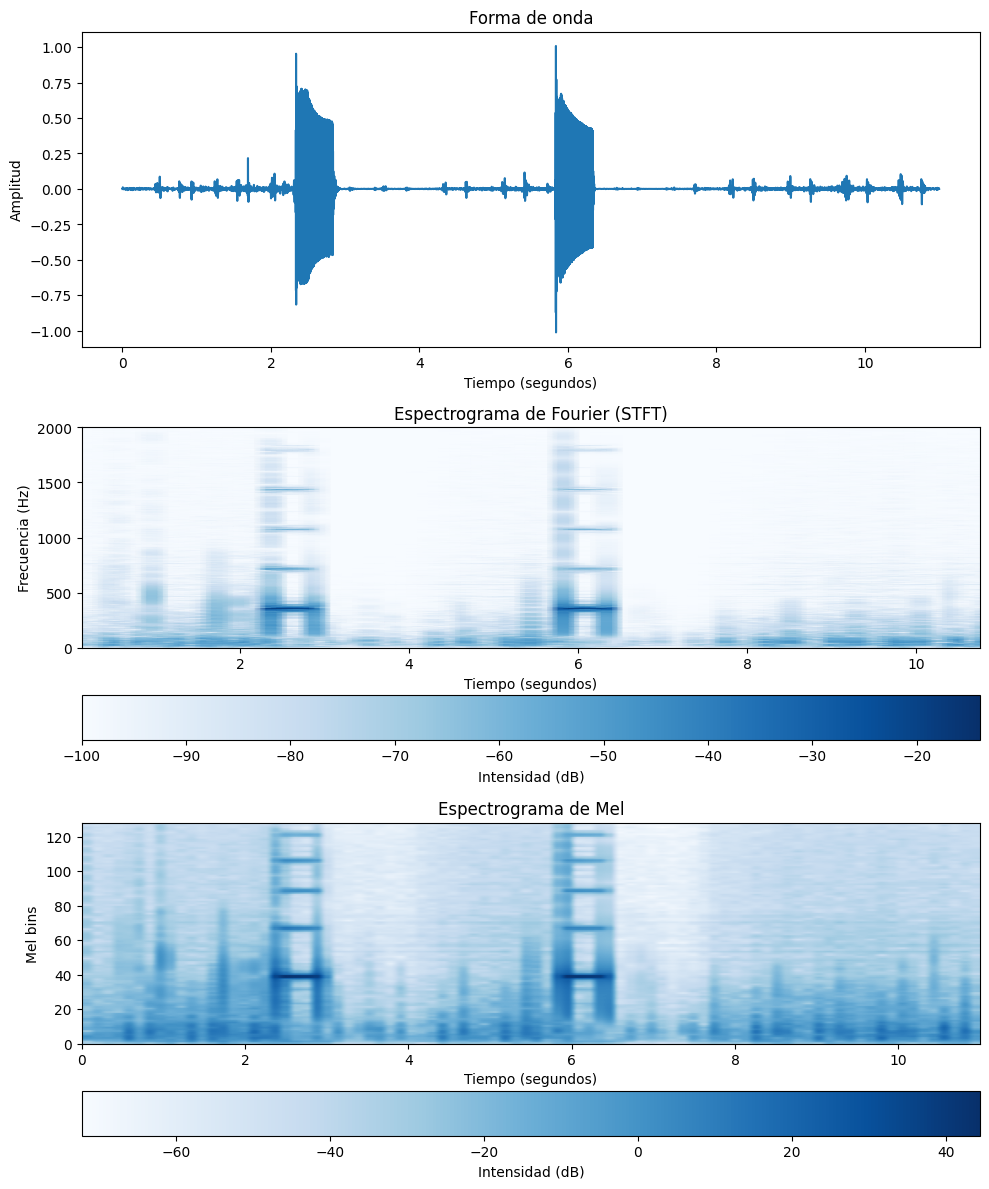

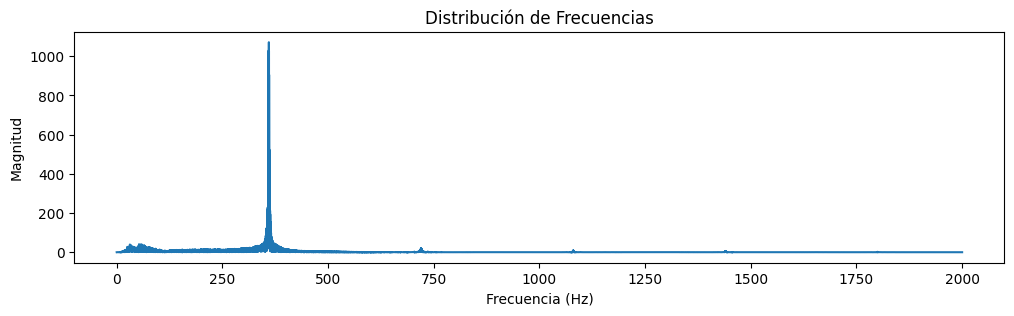

In [14]:
new_sample_rate = 4000

resampler = torchaudio.transforms.Resample(
    orig_freq=sample_rate, new_freq=new_sample_rate
)

audio = resampler(audio)
sample_rate = new_sample_rate

plot_waveform_and_spectrograms(audio, sample_rate)
plot_audio_fft(audio, sample_rate)

Audio(audio, rate=sample_rate, autoplay=True)

# Focus on synthetic frequency

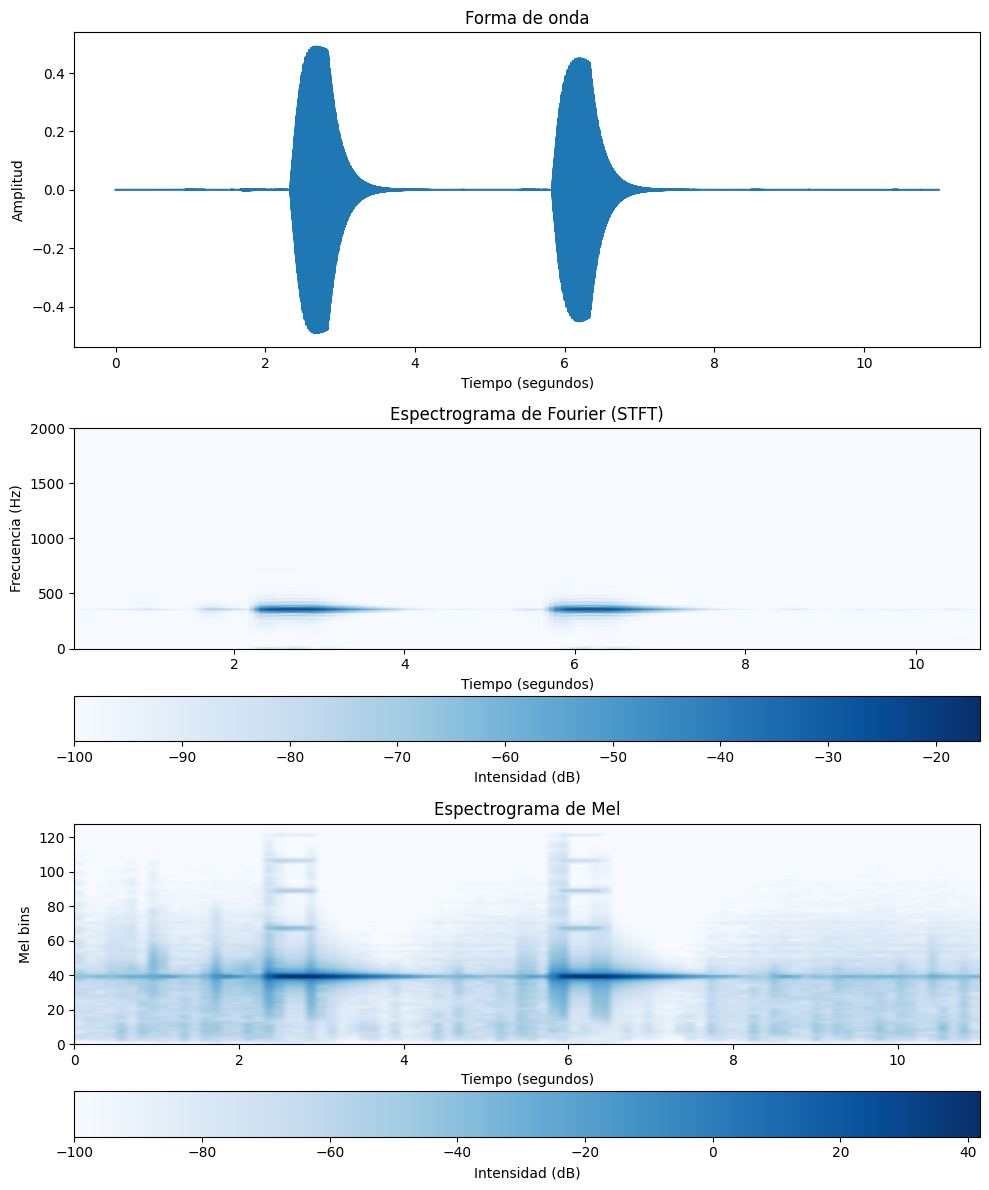

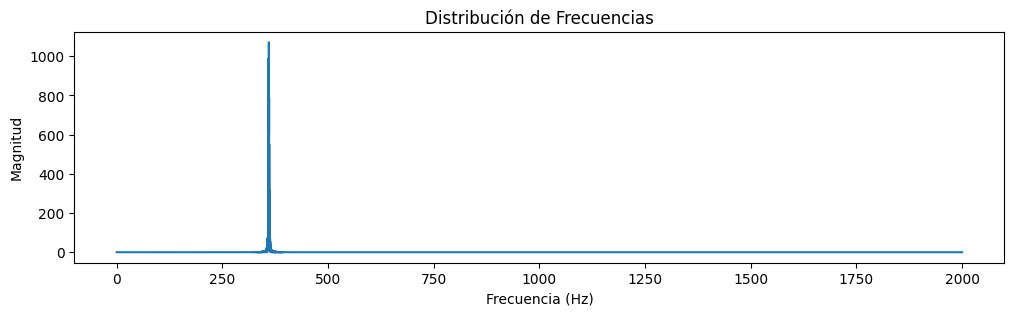

In [15]:
SYNTHETIC_FREQ = 360
low_cutoff = SYNTHETIC_FREQ - 1
high_cutoff = SYNTHETIC_FREQ + 1

filtered_audio = apply_bandpass_filter(audio, sample_rate, low_cutoff, high_cutoff)

plot_waveform_and_spectrograms(filtered_audio, sample_rate)
plot_audio_fft(filtered_audio, sample_rate)

Audio(filtered_audio, rate=sample_rate, autoplay=True)

# Absolute signal

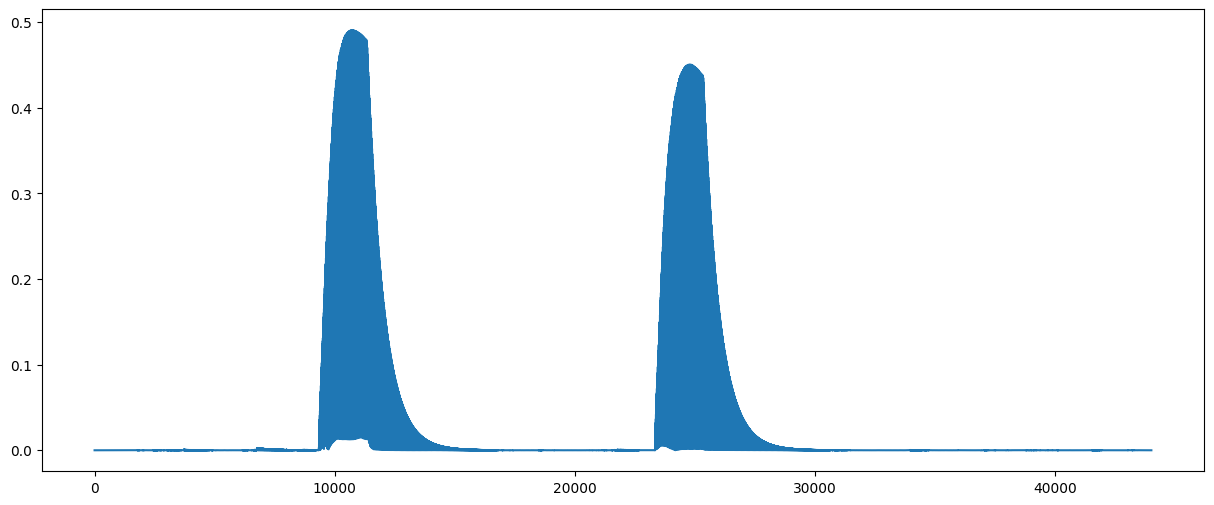

In [16]:
abs_filtered = filtered_audio.abs()

plt.figure(figsize=(15, 6))
plt.plot(abs_filtered.squeeze())

# Downsample it

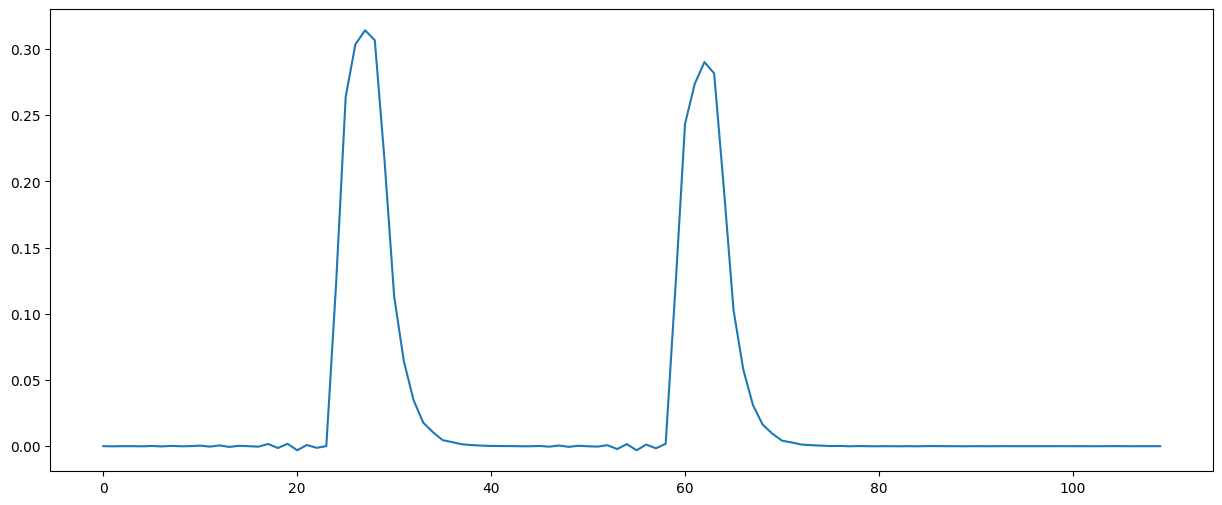

In [17]:
DOWNSAMPLE_FACTOR = 400

downsampled = decimate(abs_filtered, DOWNSAMPLE_FACTOR)

plt.figure(figsize=(15, 6))
plt.plot(downsampled.squeeze())

# Smooth it

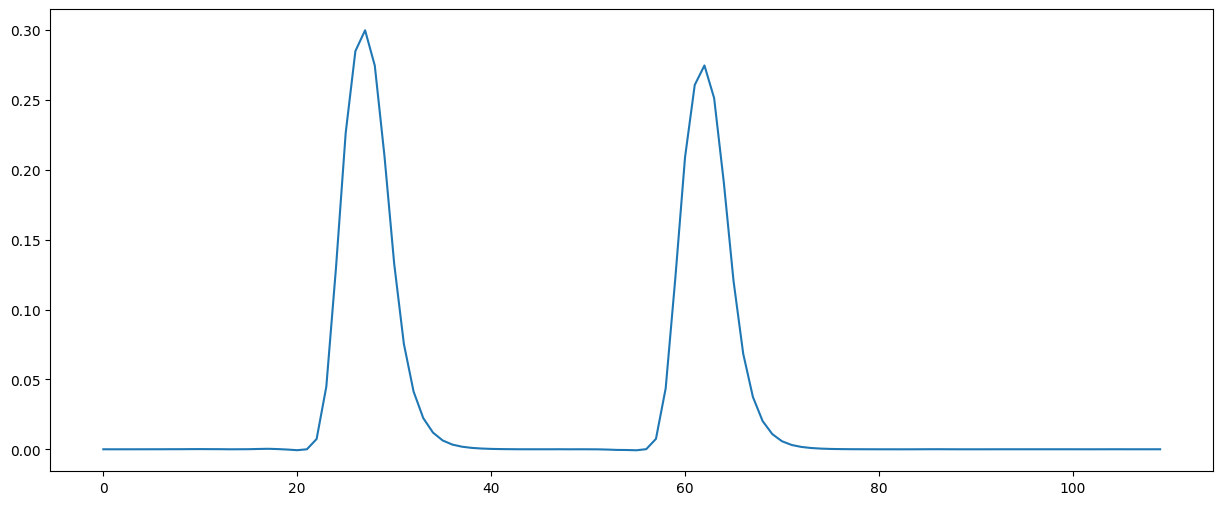

In [18]:
SIGMA_SMOOTH = 1

smoothed = gaussian_filter1d(downsampled, sigma=SIGMA_SMOOTH)

plt.figure(figsize=(15, 6))
plt.plot(smoothed.squeeze())

# Find peaks where signal changes

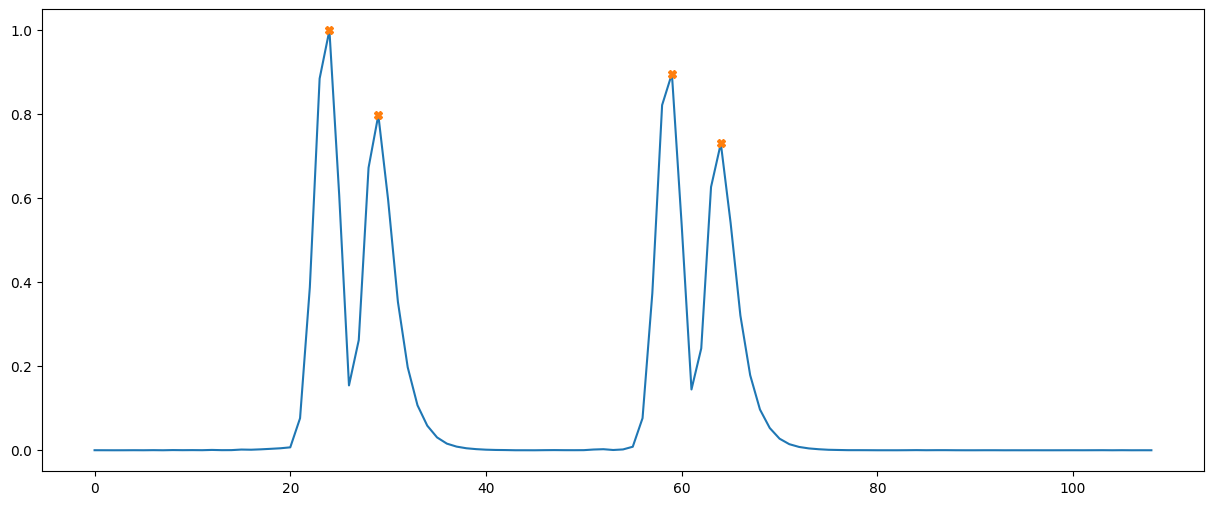

In [19]:
PEAKS_HEIGHT = 0.3
PEAKS_PROMINENCE = 0.0001

smoothed_diff = np.abs(np.diff(smoothed).squeeze())
smoothed_diff = min_max_scale(Tensor(smoothed_diff))
peaks, _ = find_peaks(smoothed_diff, height=PEAKS_HEIGHT, prominence=PEAKS_PROMINENCE)

plt.figure(figsize=(15, 6))
plt.plot(smoothed_diff)
plt.plot(peaks, smoothed_diff[peaks], "X")

# Upsample those peaks in the raw audio signal

Peaks found in downsampled signal: [24 29 59 64]
Peaks in real signal: [ 9600 11600 23600 25600]


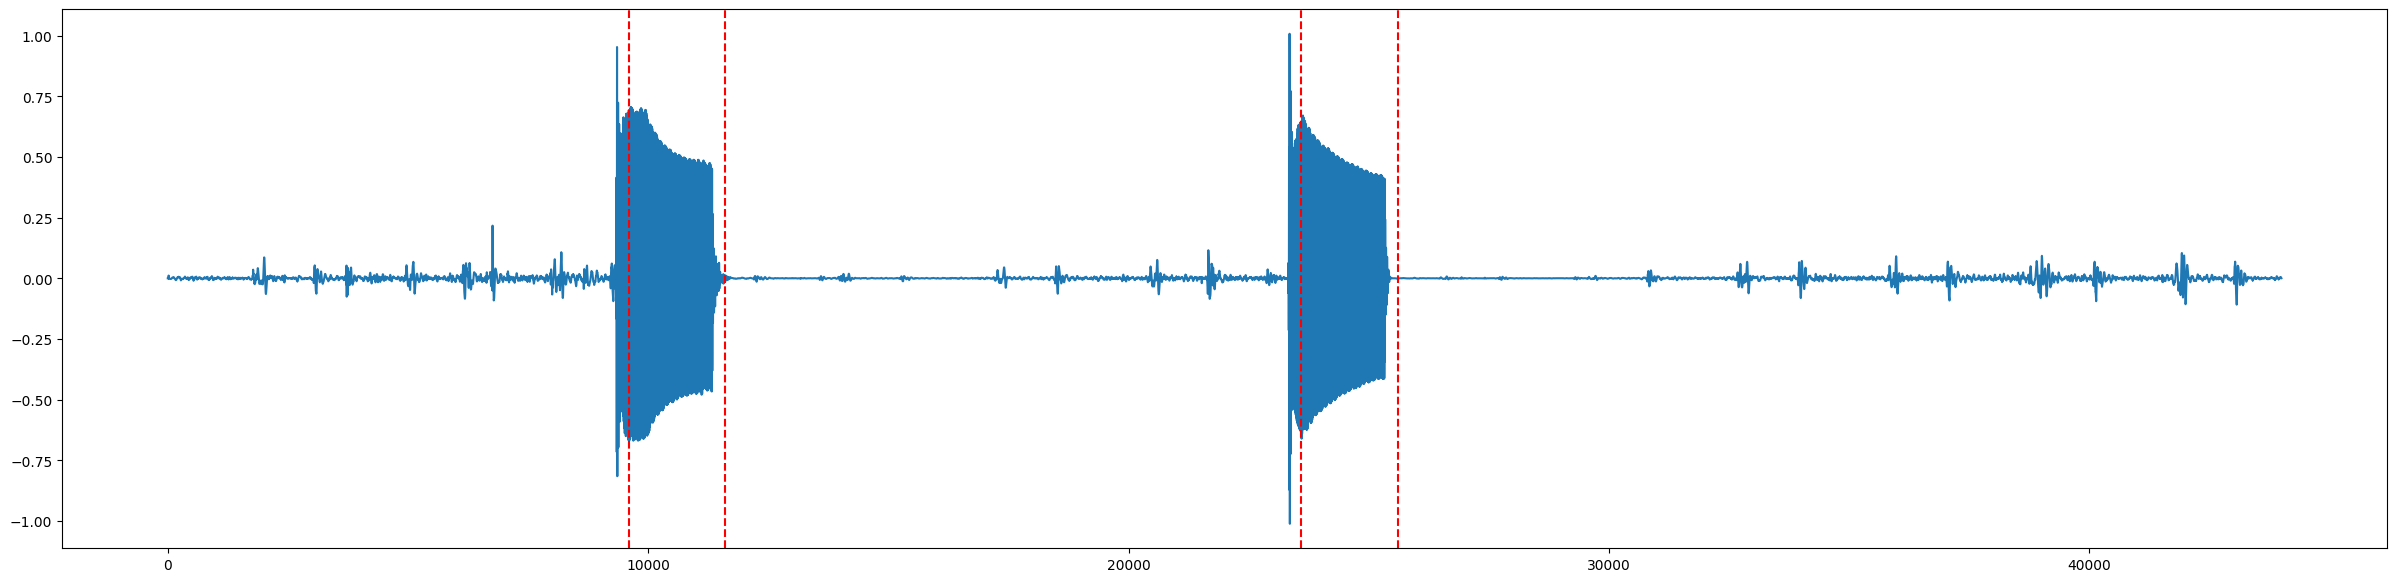

In [20]:
upsampled_peaks = peaks * DOWNSAMPLE_FACTOR
print(f"Peaks found in downsampled signal: {peaks}")
print(f"Peaks in real signal: {upsampled_peaks}")

plt.figure(figsize=(30, 7))
plt.plot(audio.squeeze())

for peak in upsampled_peaks:
    plt.axvline(x=peak, color="red", linestyle="--")

plt.show()

# Keep the audio after the last peak

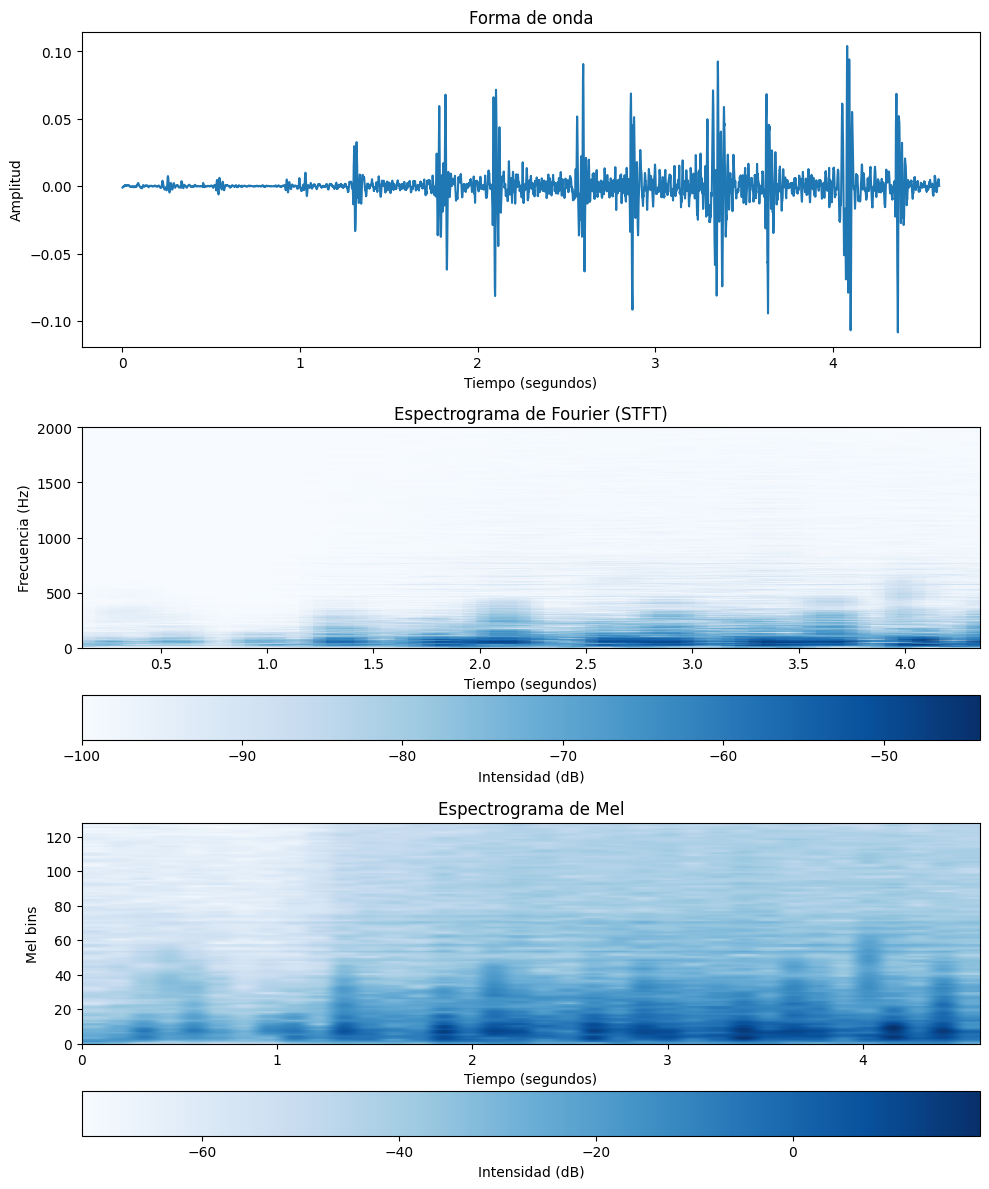

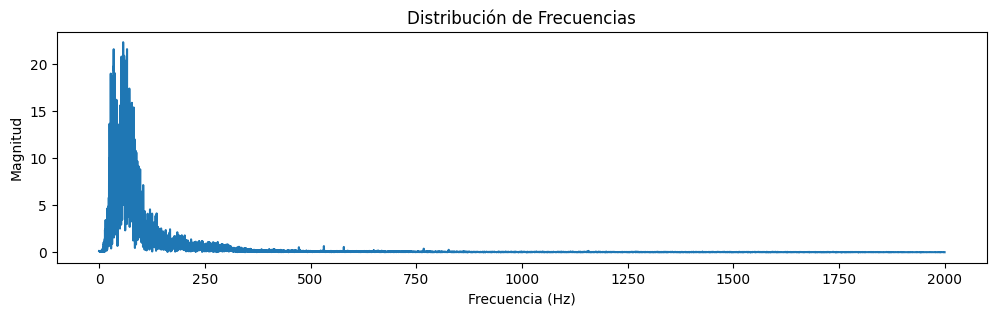

In [21]:
clean_audio = audio[:, upsampled_peaks[-1] :].clone()

plot_waveform_and_spectrograms(clean_audio, sample_rate)
plot_audio_fft(clean_audio, sample_rate)
Audio(clean_audio, rate=sample_rate, autoplay=True)